### Setup dask for machine learning

In [ ]:
%matplotlib inline

In [38]:
# Import libraries
import dask
import dask.array as da
from dask_ml.datasets import make_classification
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LogisticRegression
from dask_ml.metrics import accuracy_score
from dask_ml.model_selection import IncrementalSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

import matplotlib.pyplot as plt

import numpy as np

In [1]:
# Create random data
n, d = 35000, 162

X, y = make_classification(n_samples=n, n_features=d,
                           chunks=n // 10, flip_y=0.2)
X = X.persist()
X

dask.array<normal, shape=(35000, 162), dtype=float64, chunksize=(3500, 162)>

In [2]:
# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train

dask.array<concatenate, shape=(31500, 162), dtype=float64, chunksize=(3150, 162)>

In [6]:
# Compute the AUC, F1 and confusion matrix for the logistic regression model on the training data

lr = LogisticRegression()
lr.fit(X_train,y_train)
y_true = y_test
y_pred = lr.predict(X_test)
accuracy_score(y_true, y_pred)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
print('AUC_lr: %.3f' % metrics.auc(fpr, tpr))
print('F1_lr: %.3f' % f1_score(y_true, y_pred))

AUC_lr: 0.605
F1_lr: 0.615


[[1015  735]
 [ 646 1104]]


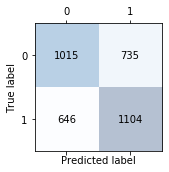

In [7]:
# Confusion matrix of test data

confmat_test = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat_test)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat_test, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_test.shape[0]):
    for j in range(confmat_test.shape[1]):
        ax.text(x=j, y=i, s=confmat_test[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

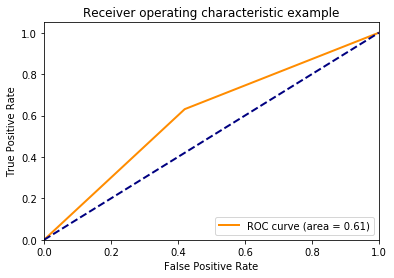

In [8]:
# Plot the ROC for your best model on the training data
# Compute ROC curve and ROC area for each class

roc_auc=metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [31]:
# What are the dimensions of your training and test data? 

print('Dimension of training data is:' , X_train.shape)
print('Dimension of test data is:' , X_test.shape)


Dimension of training data is: (31500, 162)
Dimension of test data is: (3500, 162)


### Why do we use F1 (Dice) as the scoring metric in Kaggle and not accuracy? 

#### Answer: F1 Score is needed when you want to seek a balance between Precision and Recall.  F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall AND there is an uneven class distribution (large number of Actual Negatives) (https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9). In our case, we have an uneven class distribution since most of the classes in the target at acutal negatives (0) or healthy vs. cancer (1)
